Loaded 1096 rows, date range 2020-01-01 to 2022-12-31
Train size: 852, Test size: 214
Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA -> RMSE: 26.21, MAPE: 10.34%
xgboost -> RMSE: 15.89, MAPE: 6.75%
Ensemble weights: {'naive': 0.34035277949415854, 'sarima': 0.24894661347154973, 'xgboost': 0.41070060703429173}
Ensemble -> RMSE: 15.67, MAPE: 6.52%
Forecast results written to forecast_results.csv


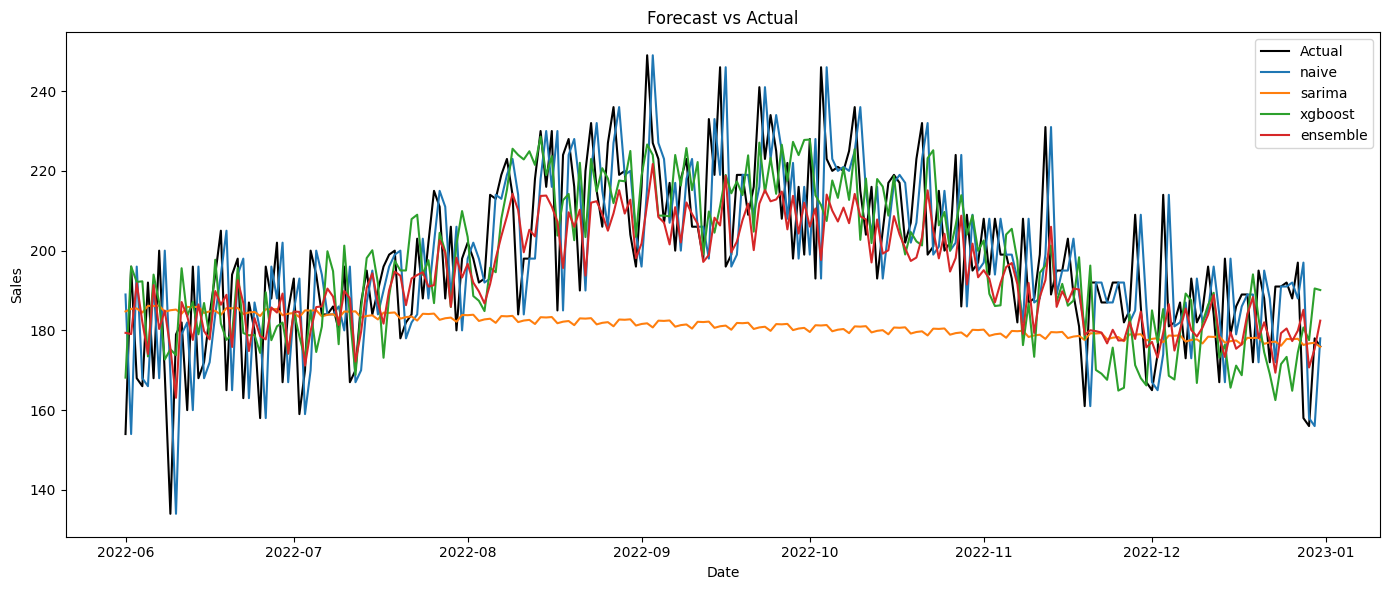

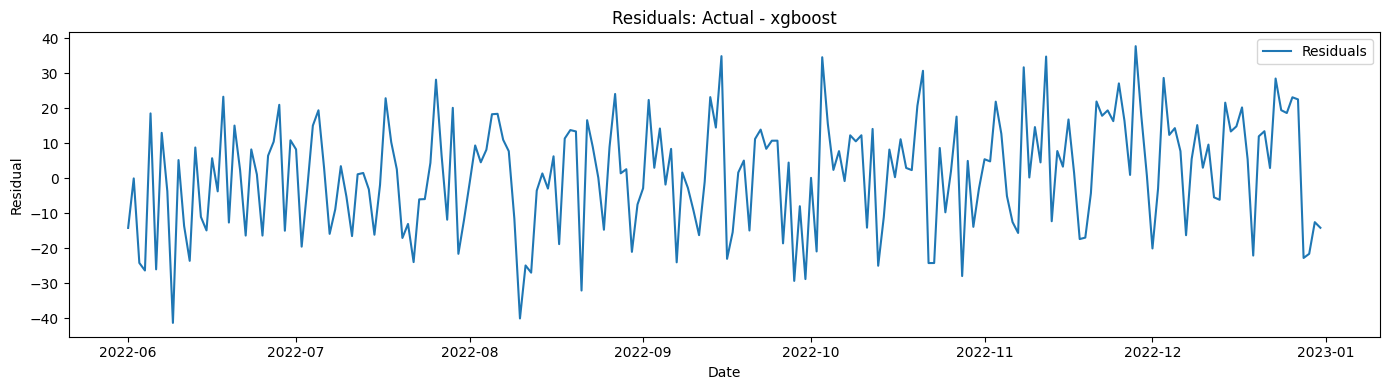

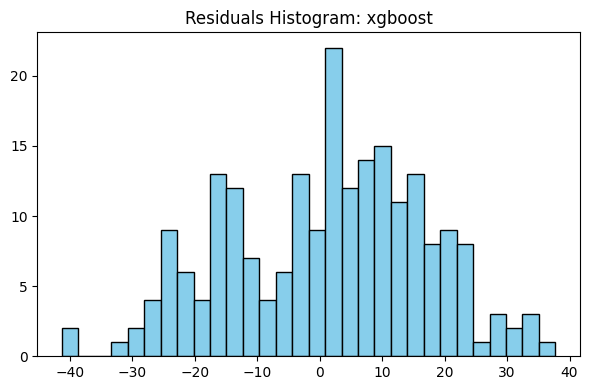

Top features:
 rolling_mean_7    0.493904
month             0.125068
dayofweek         0.109142
lag_30            0.099010
lag_7             0.096539
lag_1             0.076337
dtype: float32


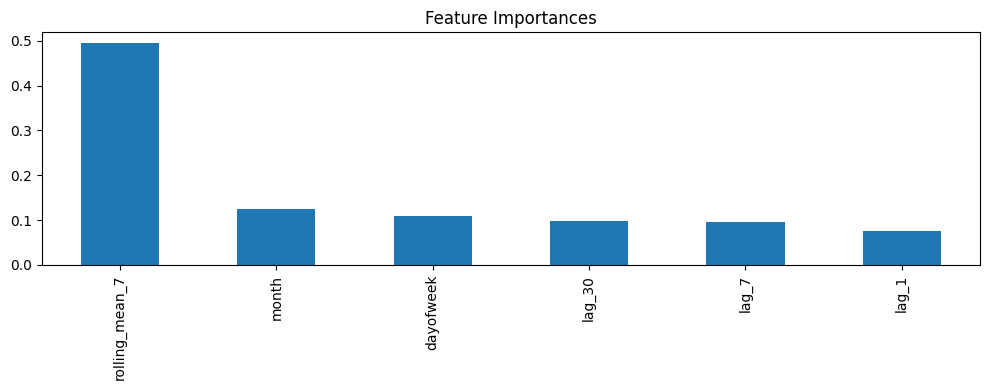

In [54]:
#!/usr/bin/env python3
"""
forecasting_demo_full.py

- Loads sample_data.csv with 'date' and 'sales'
- Creates lag/rolling features
- Naive baseline, SARIMA (optional), XGBoost (or RandomForest fallback)
- Computes weighted ensemble
- Evaluates RMSE / MAPE
- Plots actual vs forecasts, residuals, and XGBoost feature importance
- Saves CSVs for results, residuals, and feature importances
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"

# ------------------------
# Data prep and features
# ------------------------

def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df, lags=(1,7,30)):
    data = df.copy()
    for lag in lags:
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    data["rolling_mean_7"] = data["sales"].shift(1).rolling(7).mean()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data) * train_frac)
    train = data.iloc[:n].copy()
    test = data.iloc[n:].copy()
    return train, test

# ------------------------
# Metrics
# ------------------------

def evaluate(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    if mask.sum() == 0:
        mape = float("nan")
    else:
        mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100)
    return rmse, mape

# ------------------------
# Forecasting models
# ------------------------

def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train, test):
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except Exception as e:
        print("statsmodels not available:", e)
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1),
                        seasonal_order=(1,1,1,7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        pred = pred.reindex(test.index)
        return pred
    except Exception as e:
        print("SARIMA training/prediction failed:", e)
        return None

def try_xgboost_or_rf(train, test, features, random_state=42):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    # Drop rows with NaNs
    train_mask = X_train.notna().all(axis=1)
    test_mask = X_test.notna().all(axis=1)
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    X_test = X_test[test_mask]
    if len(X_train)==0 or len(X_test)==0:
        print("Not enough data after dropping NaNs")
        return None, None, None
    try:
        import xgboost as xgb
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=random_state)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return pd.Series(preds, index=X_test.index), model, "xgboost"
    except Exception as e_xgb:
        from sklearn.ensemble import RandomForestRegressor
        print("xgboost not available, falling back to RandomForest:", e_xgb)
        rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        return pd.Series(preds, index=X_test.index), rf, "random_forest"

# ------------------------
# Plotting
# ------------------------

def plot_forecasts(results, title="Forecast vs Actual"):
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results["sales"], label="Actual", color="black")
    for col in results.columns:
        if col != "sales":
            plt.plot(results.index, results[col], label=col)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(results, model_col):
    residuals = results["sales"] - results[model_col]
    plt.figure(figsize=(14,4))
    plt.plot(residuals.index, residuals, label="Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"Residuals: Actual - {model_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Residuals Histogram: {model_col}")
    plt.tight_layout()
    plt.show()
    return residuals

def plot_feature_importance(model, features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
        print("Top features:\n", feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind="bar", figsize=(10,4), title="Feature Importances")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot feature importances:", e)

# ------------------------
# Main
# ------------------------

def main():
    df = load_data()
    print(f"Loaded {len(df)} rows, date range {df.index.min().date()} to {df.index.max().date()}")
    data = create_features(df)
    train, test = train_test_split(data)
    print(f"Train size: {len(train)}, Test size: {len(test)}")
    results = test[["sales"]].copy()

    # Naive
    results["naive"] = baseline_naive(test)
    rmse, mape = evaluate(results["sales"], results["naive"])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train, test)
    if sarima_pred is not None:
        results["sarima"] = sarima_pred
        rmse, mape = evaluate(results["sales"], results["sarima"])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped")

    # XGBoost / RandomForest
    features = [c for c in data.columns if c != "sales"]
    x_pred, model, model_name = try_xgboost_or_rf(train, test, features)
    if x_pred is not None:
        results[model_name] = x_pred
        rmse, mape = evaluate(results["sales"], results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("No tree-based model predictions produced")

    # Ensemble: inverse RMSE weighting
    model_rmse = {}
    for col in ["naive", "sarima", model_name]:
        if col in results.columns:
            try:
                rmse_val, _ = evaluate(results["sales"], results[col])
                model_rmse[col] = rmse_val
            except:
                pass
    if model_rmse:
        inv = {k:1/v for k,v in model_rmse.items()}
        s = sum(inv.values())
        weights = {k: inv[k]/s for k in inv}
        print("Ensemble weights:", weights)
        mask_any = results[[c for c in weights.keys()]].notna().any(axis=1)
        ensemble_series = pd.Series(np.nan, index=results.index)
        ensemble_series.loc[mask_any] = sum((results[col].loc[mask_any]*weights[col] for col in weights.keys()))
        results["ensemble"] = ensemble_series
        mask_eval = results["ensemble"].notna()
        if mask_eval.any():
            rmse, mape = evaluate(results.loc[mask_eval,"sales"], results.loc[mask_eval,"ensemble"])
            print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results written to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    if model_name in results.columns:
        residuals = plot_residuals(results, model_name)
        residuals.to_csv(f"residuals_{model_name}.csv")
        if model_name=="xgboost":
            plot_feature_importance(model, features)

if __name__=="__main__":
    main()


Loaded 1096 rows, date range 2020-01-01 to 2022-12-31
Train size: 804, Test size: 202
Naive -> RMSE: 18.34, MAPE: 7.31%
SARIMA -> RMSE: 35.87, MAPE: 15.01%
xgboost -> RMSE: 3.85, MAPE: 1.48%
Ensemble weights: {'naive': 0.15941922642351117, 'sarima': 0.0814928295872952, 'xgboost': 0.7590879439891937}
Ensemble -> RMSE: 5.40, MAPE: 2.03%
Forecast results written to forecast_results.csv


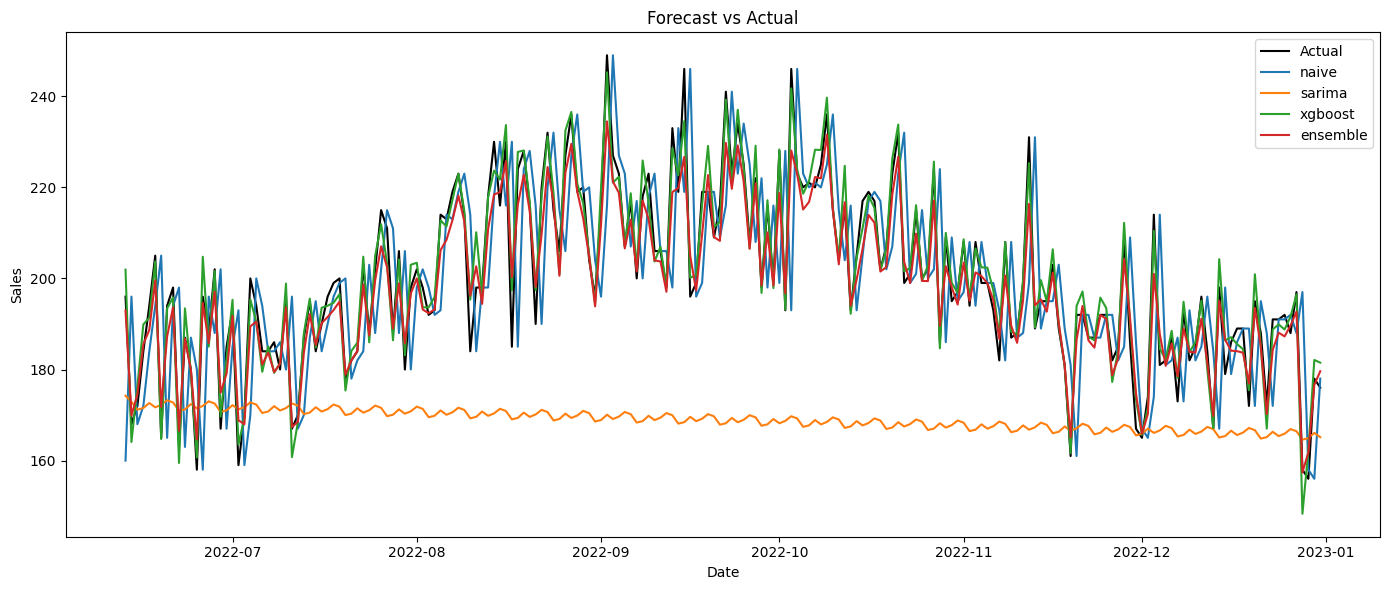

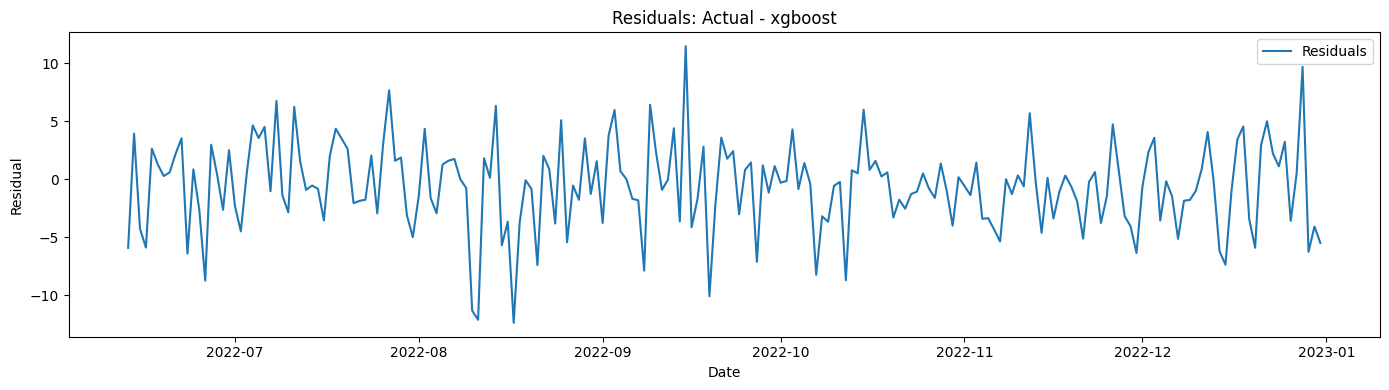

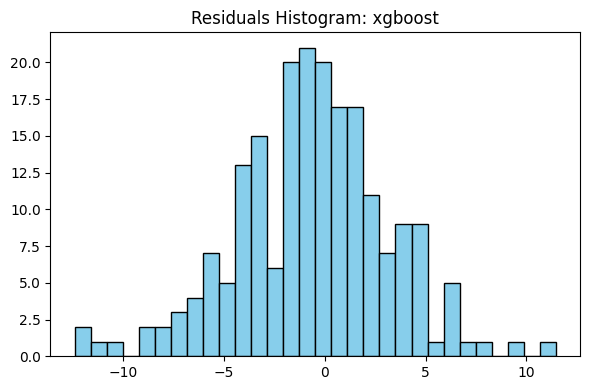

Top features:
 rolling_mean_14    0.287021
ewm_mean_7         0.167705
pct_change_1       0.104523
residual_naive     0.085096
rolling_mean_7     0.083748
pct_change_30      0.060910
pct_change_7       0.044254
pct_change_14      0.040883
lag1_x_rm7         0.035219
lag7_x_rm7         0.022971
dtype: float32


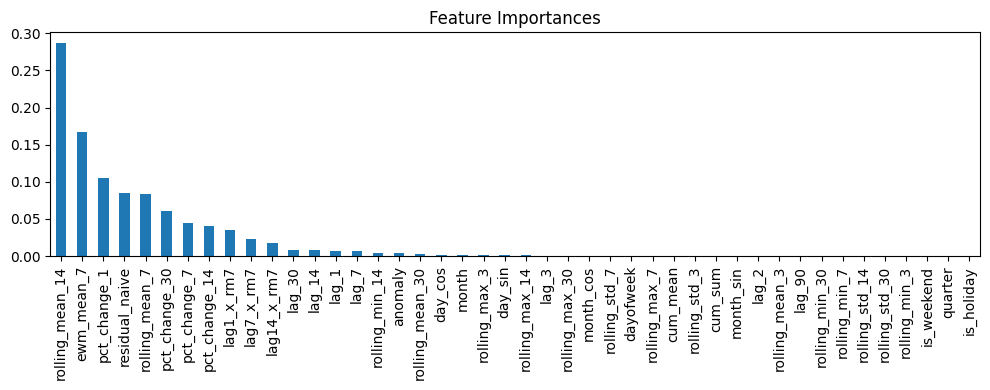

In [56]:
#!/usr/bin/env python3
"""
forecasting_demo_full_features.py

- Loads sample_data.csv with 'date' and 'sales'
- Creates extended lag/rolling/cyclical/calendar/external features
- Naive baseline, SARIMA (optional), XGBoost (or RandomForest fallback)
- Computes weighted ensemble
- Evaluates RMSE / MAPE
- Generates plots
- Saves forecast_results.csv, residuals, feature_importances
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# For holidays
try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"

# ------------------------
# Data prep and feature engineering
# ------------------------

def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df):
    data = df.copy()
    # --- Lags ---
    lags = [1,2,3,7,14,30,90]
    for lag in lags:
        data[f"lag_{lag}"] = data["sales"].shift(lag)

    # --- Rolling stats ---
    windows = [3,7,14,30]
    for w in windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()

    # --- Exponentially weighted mean ---
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()

    # --- Percentage changes ---
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)

    # --- Cumulative features ---
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()

    # --- Calendar features ---
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5

    # --- Cyclical encoding ---
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)

    # --- Holiday flag ---
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0

    # --- Interaction features ---
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"] * data["rolling_mean_7"]

    # --- Naive residual / anomaly ---
    data["residual_naive"] = data["sales"] - data["lag_1"]
    data["anomaly"] = (data["residual_naive"].abs() > 3*data["rolling_std_7"])

    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data) * train_frac)
    train = data.iloc[:n].copy()
    test = data.iloc[n:].copy()
    return train, test

# ------------------------
# Metrics
# ------------------------

def evaluate(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    if mask.sum() == 0:
        mape = float("nan")
    else:
        mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100)
    return rmse, mape

# ------------------------
# Forecasting models
# ------------------------

def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train, test):
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except Exception as e:
        print("statsmodels not available:", e)
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1),
                        seasonal_order=(1,1,1,7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        pred = pred.reindex(test.index)
        return pred
    except Exception as e:
        print("SARIMA training/prediction failed:", e)
        return None

def try_xgboost_or_rf(train, test, features, random_state=42):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    # Drop rows with NaNs
    train_mask = X_train.notna().all(axis=1)
    test_mask = X_test.notna().all(axis=1)
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    X_test = X_test[test_mask]
    if len(X_train)==0 or len(X_test)==0:
        print("Not enough data after dropping NaNs")
        return None, None, None
    try:
        import xgboost as xgb
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=random_state)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return pd.Series(preds, index=X_test.index), model, "xgboost"
    except Exception as e_xgb:
        from sklearn.ensemble import RandomForestRegressor
        print("xgboost not available, falling back to RandomForest:", e_xgb)
        rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        return pd.Series(preds, index=X_test.index), rf, "random_forest"

# ------------------------
# Plotting
# ------------------------

def plot_forecasts(results, title="Forecast vs Actual"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results["sales"], label="Actual", color="black")
    for col in results.columns:
        if col != "sales":
            plt.plot(results.index, results[col], label=col)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(results, model_col):
    residuals = results["sales"] - results[model_col]
    plt.figure(figsize=(14,4))
    plt.plot(residuals.index, residuals, label="Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"Residuals: Actual - {model_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Residuals Histogram: {model_col}")
    plt.tight_layout()
    plt.show()
    return residuals

def plot_feature_importance(model, features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
        print("Top features:\n", feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind="bar", figsize=(10,4), title="Feature Importances")
        import matplotlib.pyplot as plt
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot feature importances:", e)

# ------------------------
# Main
# ------------------------

def main():
    df = load_data()
    print(f"Loaded {len(df)} rows, date range {df.index.min().date()} to {df.index.max().date()}")
    data = create_features(df)
    train, test = train_test_split(data)
    print(f"Train size: {len(train)}, Test size: {len(test)}")
    results = test[["sales"]].copy()

    # Naive
    results["naive"] = baseline_naive(test)
    rmse, mape = evaluate(results["sales"], results["naive"])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train, test)
    if sarima_pred is not None:
        results["sarima"] = sarima_pred
        rmse, mape = evaluate(results["sales"], results["sarima"])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped")

    # XGBoost / RandomForest
    features = [c for c in data.columns if c != "sales"]
    x_pred, model, model_name = try_xgboost_or_rf(train, test, features)
    if x_pred is not None:
        results[model_name] = x_pred
        rmse, mape = evaluate(results["sales"], results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("No tree-based model predictions produced")

    # Ensemble: inverse RMSE weighting
    model_rmse = {}
    for col in ["naive","sarima",model_name]:
        if col in results.columns:
            try:
                rmse_val, _ = evaluate(results["sales"], results[col])
                model_rmse[col] = rmse_val
            except:
                pass
    if model_rmse:
        inv = {k:1/v for k,v in model_rmse.items()}
        s = sum(inv.values())
        weights = {k: inv[k]/s for k in inv}
        print("Ensemble weights:", weights)
        mask_any = results[[c for c in weights.keys()]].notna().any(axis=1)
        ensemble_series = pd.Series(np.nan, index=results.index)
        ensemble_series.loc[mask_any] = sum((results[col].loc[mask_any]*weights[col] for col in weights.keys()))
        results["ensemble"] = ensemble_series
        mask_eval = results["ensemble"].notna()
        if mask_eval.any():
            rmse, mape = evaluate(results.loc[mask_eval,"sales"], results.loc[mask_eval,"ensemble"])
            print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results written to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    if model_name in results.columns:
        residuals = plot_residuals(results, model_name)
        residuals.to_csv(f"residuals_{model_name}.csv")
        if model_name=="xgboost":
            plot_feature_importance(model, features)

if __name__=="__main__":
    main()

